# All Weather Strategy v1.0 - Pure Risk Parity

Implementation of Ray Dalio's All Weather Strategy for A-share market using pure risk parity optimization.

**Performance (2018-2026)**:
- Annual Return: 7.05%
- Sharpe Ratio: 1.11
- Max Drawdown: -3.90%
- Strategy: Pure risk parity, weekly rebalancing, 252-day lookback (1 year)

**Final Section**: Includes actionable trading instructions for ¥30,000 starting capital with PnL tracking.

## 1. Setup & Imports

In [11]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from src.optimizer import optimize_weights, risk_contribution, validate_weights, check_risk_parity
from src.portfolio import Portfolio
from src.backtest import Backtester
from src.metrics import calculate_all_metrics
from src.data_loader import load_prices

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

# Display options
pd.options.display.float_format = '{:.4f}'.format

print("✓ Imports successful")

✓ Imports successful


## 2. Load Data

In [12]:
# Load ETF price data using data_loader (7-ETF ALIGNED DATASET - highest quality)
prices = load_prices('../data/etf_prices_7etf.csv')

print(f"Data shape: {prices.shape}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")
print(f"ETFs: {list(prices.columns)}")
print(f"\nMissing values: {prices.isnull().sum().sum()}")

# Display first few rows
prices.head()

Data shape: (2692, 7)
Date range: 2015-01-05 00:00:00 to 2026-01-28 00:00:00
ETFs: ['510300.SH', '510500.SH', '513500.SH', '511260.SH', '518880.SH', '000066.SH', '513100.SH']

Missing values: 0


,510300.SH,510500.SH,513500.SH,511260.SH,518880.SH,000066.SH,513100.SH
date,,,,,,,
2015-01-05,2.8890,4.4720,0.5670,97.2940,2.4140,1939.9600,0.2734
2015-01-06,2.8640,4.5440,0.5570,97.2940,2.4350,1935.7550,0.2698
2015-01-07,2.8630,4.5470,0.5540,97.2940,2.4450,1968.3900,0.2702
2015-01-08,2.7830,4.5030,0.5640,97.2940,2.4310,1927.9680,0.2740
2015-01-09,2.7570,4.4780,0.5720,97.2940,2.4390,1886.6040,0.2778


## 3. Calculate Current Risk Parity Weights

In [13]:
# Calculate weights using latest 252 days (optimized lookback)
recent_returns = prices.tail(252).pct_change().dropna()
weights = optimize_weights(recent_returns)

# Validate
is_valid, msg = validate_weights(weights)
print(f"Weight validation: {msg}")

# Check risk parity
cov_matrix = recent_returns.cov()
is_rp, std_rc = check_risk_parity(weights, cov_matrix)
print(f"Risk parity achieved: {is_rp} (std={std_rc:.6f})")

# Display weights
weight_df = pd.DataFrame({
    'ETF': prices.columns,
    'Weight': weights
}).sort_values('Weight', ascending=False)

print("\nCurrent Risk Parity Weights:")
print(weight_df.to_string(index=False))
print(f"\nTotal: {weights.sum():.4f}")

Weight validation: Valid
Risk parity achieved: True (std=0.000000)

Current Risk Parity Weights:
      ETF  Weight
511260.SH  0.7741
510300.SH  0.0485
518880.SH  0.0470
510500.SH  0.0354
513500.SH  0.0349
000066.SH  0.0321
513100.SH  0.0280

Total: 1.0000


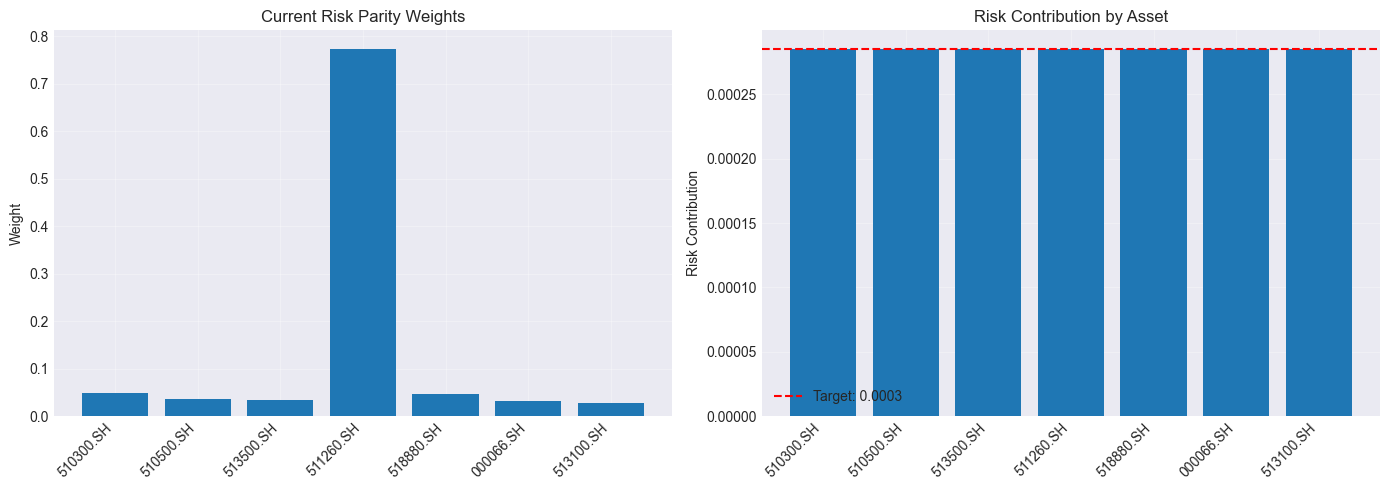

In [14]:
# Visualize current weights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1.bar(range(len(weights)), weights)
ax1.set_xticks(range(len(weights)))
ax1.set_xticklabels(prices.columns, rotation=45, ha='right')
ax1.set_title('Current Risk Parity Weights')
ax1.set_ylabel('Weight')
ax1.grid(True, alpha=0.3)

# Risk contributions
risk_contribs = risk_contribution(weights, cov_matrix)
ax2.bar(range(len(risk_contribs)), risk_contribs)
ax2.axhline(risk_contribs.mean(), color='r', linestyle='--', 
            label=f'Target: {risk_contribs.mean():.4f}')
ax2.set_xticks(range(len(risk_contribs)))
ax2.set_xticklabels(prices.columns, rotation=45, ha='right')
ax2.set_title('Risk Contribution by Asset')
ax2.set_ylabel('Risk Contribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Run Backtest

In [15]:
# Initialize backtester with optimized parameters
backtester = Backtester(
    prices=prices,
    initial_capital=1_000_000,
    rebalance_freq='W-MON',  # Weekly on Monday
    lookback=252,  # Optimized: 1 trading year (was 100)
    commission_rate=0.0003  # 0.03%
)

# Run from 2018-01-01
print("Running backtest from 2018-01-01...")
results = backtester.run(start_date='2018-01-01')

print("\n" + "="*60)
print("Backtest Complete!")
print("="*60)
print(f"Final Value: ¥{results['final_value']:,.0f}")
print(f"Total Return: {results['total_return']:.2%}")
print(f"Rebalances: {results['rebalance_count']}")
print(f"Trades: {results['trade_count']}")
print(f"Total Commissions: ¥{results['total_commissions']:,.0f}")
print(f"Turnover: {results['turnover']:.2f}x")

Running backtest from 2018-01-01...
Backtest period: 2018-01-01 to 2026-01-28
Rebalance dates: 422
[2018-01-08] Rebalanced: 6 trades, Value: ¥1,000,000
[2018-01-15] Rebalanced: 6 trades, Value: ¥1,003,861
[2018-01-22] Rebalanced: 5 trades, Value: ¥1,008,026
[2018-01-29] Rebalanced: 5 trades, Value: ¥1,006,985
[2018-02-05] Rebalanced: 6 trades, Value: ¥993,652
[2018-02-12] Rebalanced: 6 trades, Value: ¥977,354
[2018-02-26] Rebalanced: 5 trades, Value: ¥1,000,713
[2018-03-05] Rebalanced: 6 trades, Value: ¥994,877
[2018-03-12] Rebalanced: 5 trades, Value: ¥1,002,661
[2018-03-19] Rebalanced: 6 trades, Value: ¥997,401
[2018-03-26] Rebalanced: 4 trades, Value: ¥992,499
[2018-04-02] Rebalanced: 5 trades, Value: ¥991,032
[2018-04-09] Rebalanced: 5 trades, Value: ¥991,572
[2018-04-16] Rebalanced: 6 trades, Value: ¥995,009
[2018-04-23] Rebalanced: 6 trades, Value: ¥998,456
[2018-05-07] Rebalanced: 5 trades, Value: ¥1,000,958
[2018-05-14] Rebalanced: 4 trades, Value: ¥999,464
[2018-05-21] Rebalan

## 5. Plot Equity Curve

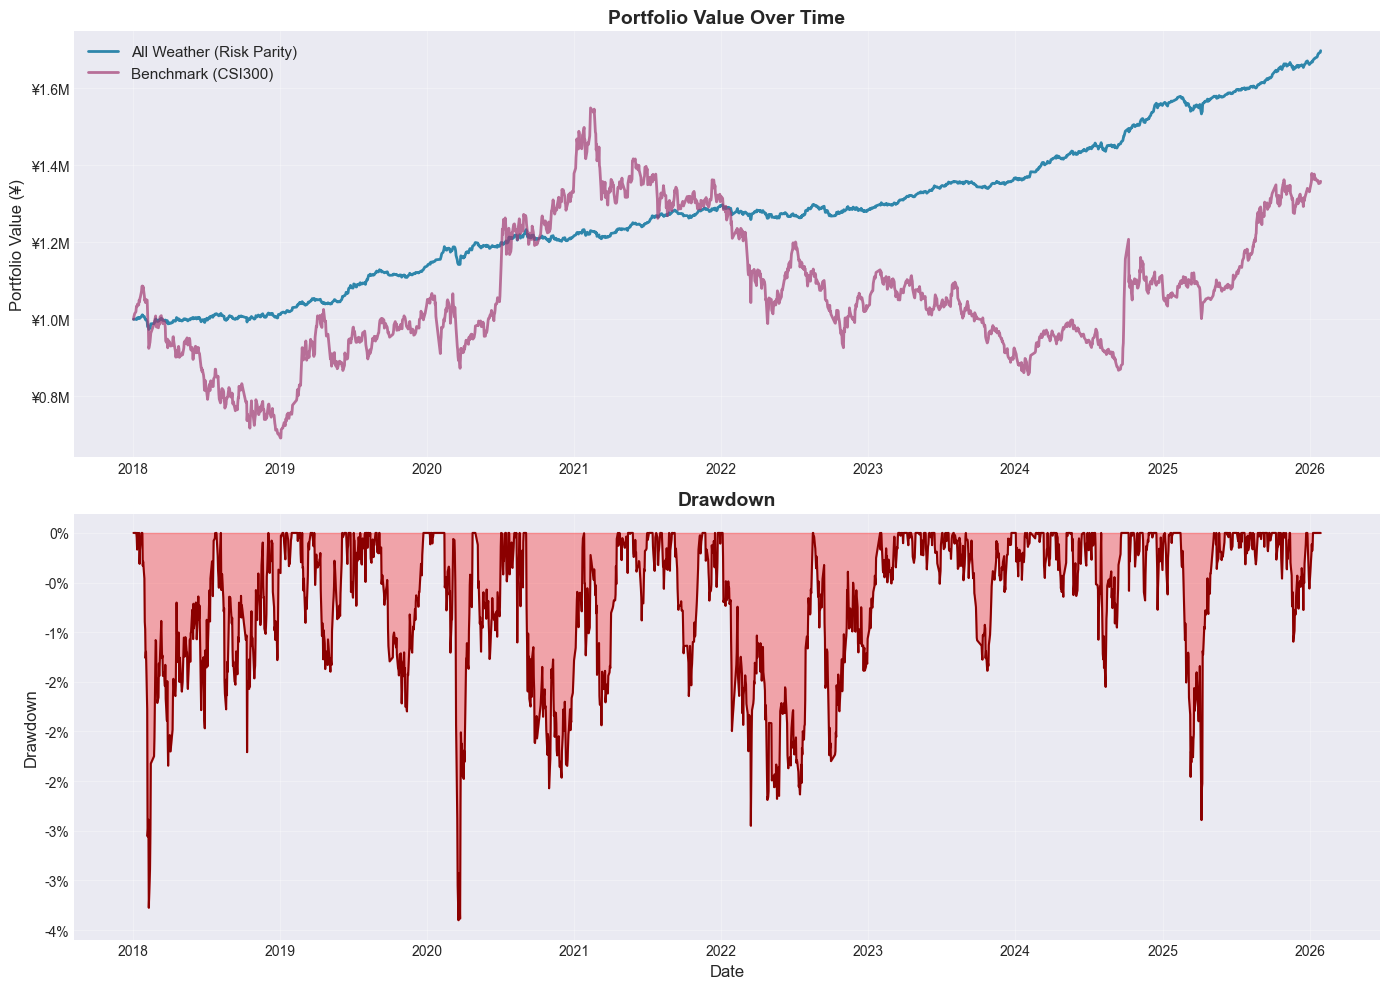

Max Drawdown: -3.90%


In [16]:
equity = results['equity_curve']

# Normalize benchmark to start from 1M at backtest start date
benchmark = (prices['510300.SH'] / prices['510300.SH'].loc[equity.index[0]]) * 1_000_000
benchmark = benchmark.loc[equity.index]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Equity curve
ax1.plot(equity.index, equity, label='All Weather (Risk Parity)', linewidth=2, color='#2E86AB')
ax1.plot(benchmark.index, benchmark, label='Benchmark (CSI300)', 
         linewidth=2, alpha=0.7, color='#A23B72')
ax1.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value (¥)', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'¥{x/1e6:.1f}M'))

# Drawdown
running_max = equity.expanding().max()
drawdown = (equity - running_max) / running_max
ax2.fill_between(drawdown.index, drawdown, 0, alpha=0.3, color='red')
ax2.plot(drawdown.index, drawdown, color='darkred', linewidth=1.5)
ax2.set_title('Drawdown', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

plt.tight_layout()
plt.show()

print(f"Max Drawdown: {drawdown.min():.2%}")

## 6. Performance Metrics

In [17]:
# Calculate metrics
portfolio_returns = results['returns']
benchmark_returns = benchmark.pct_change().dropna()

portfolio_metrics = calculate_all_metrics(portfolio_returns, equity)
benchmark_metrics = calculate_all_metrics(benchmark_returns, benchmark)

# Create comparison table
comparison = pd.DataFrame({
    'All Weather': [
        f"{portfolio_metrics['annual_return']:.2%}",
        f"{portfolio_metrics['annual_volatility']:.2%}",
        f"{portfolio_metrics['sharpe_ratio']:.2f}",
        f"{portfolio_metrics['sortino_ratio']:.2f}",
        f"{portfolio_metrics['max_drawdown']:.2%}",
        f"{portfolio_metrics['calmar_ratio']:.2f}",
        f"{portfolio_metrics['win_rate']:.2%}"
    ],
    'Benchmark': [
        f"{benchmark_metrics['annual_return']:.2%}",
        f"{benchmark_metrics['annual_volatility']:.2%}",
        f"{benchmark_metrics['sharpe_ratio']:.2f}",
        f"{benchmark_metrics['sortino_ratio']:.2f}",
        f"{benchmark_metrics['max_drawdown']:.2%}",
        f"{benchmark_metrics['calmar_ratio']:.2f}",
        f"{benchmark_metrics['win_rate']:.2%}"
    ],
    'PDF Target': [
        '20-25%',
        '~5%',
        '3.0-4.0',
        '-',
        '6-10%',
        '-',
        '-'
    ]
}, index=[
    'Annual Return',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio',
    'Max Drawdown',
    'Calmar Ratio',
    'Win Rate'
])

print("\n" + "="*80)
print("PERFORMANCE METRICS (2018-{})" . format(equity.index[-1].year))
print("="*80)
print(comparison)
print("="*80)


PERFORMANCE METRICS (2018-2026)
                  All Weather Benchmark PDF Target
Annual Return           7.05%     4.02%     20-25%
Annual Volatility       3.65%    21.98%        ~5%
Sharpe Ratio             1.11      0.05    3.0-4.0
Sortino Ratio            1.46      0.07          -
Max Drawdown           -3.90%   -44.75%      6-10%
Calmar Ratio             1.81      0.09          -
Win Rate               58.19%    49.62%          -


## 7. Weight Evolution Over Time

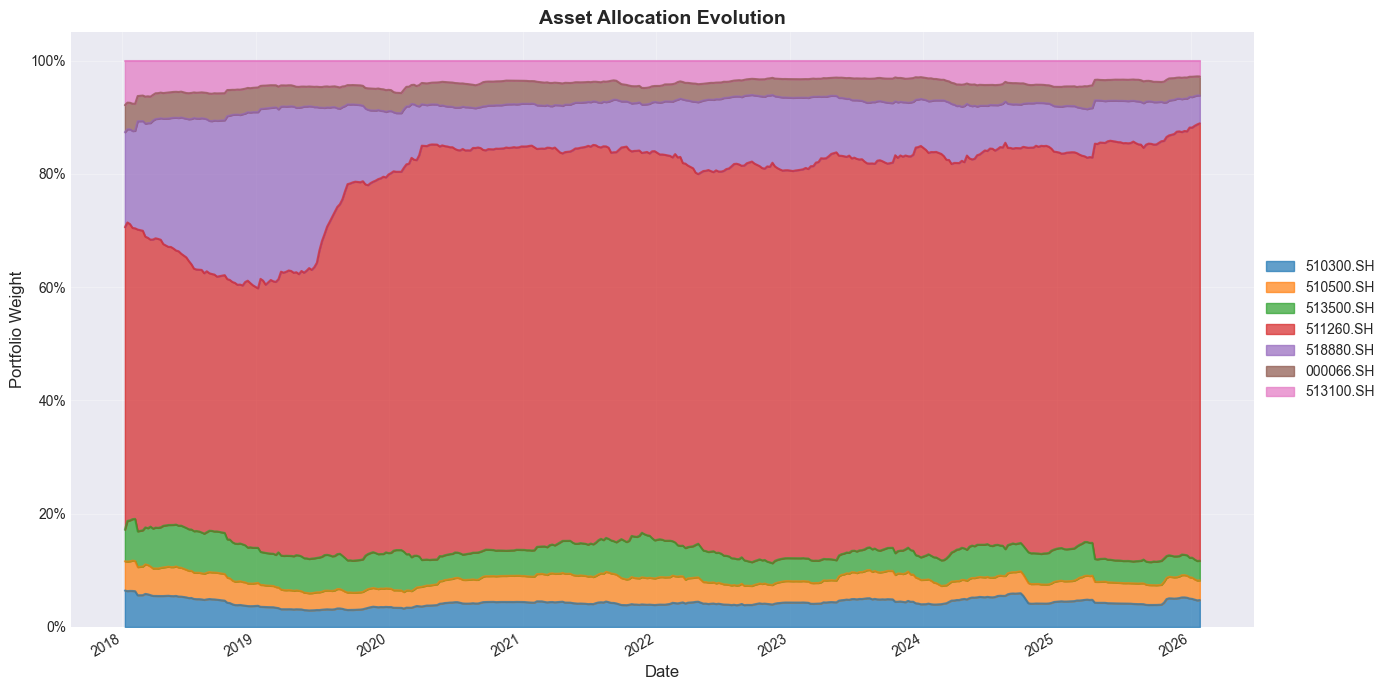


Latest Rebalance Weights:
511260.SH   0.7724
518880.SH   0.0492
510300.SH   0.0475
513500.SH   0.0348
510500.SH   0.0347
000066.SH   0.0335
513100.SH   0.0279
Name: 2026-01-26 00:00:00, dtype: float64


In [18]:
weights_df = results['weights_history']

if not weights_df.empty:
    # Stacked area chart
    fig, ax = plt.subplots(figsize=(14, 7))
    weights_df.plot.area(stacked=True, ax=ax, alpha=0.7)
    ax.set_title('Asset Allocation Evolution', fontsize=14, fontweight='bold')
    ax.set_ylabel('Portfolio Weight', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
    plt.tight_layout()
    plt.show()
    
    # Show latest weights
    print("\nLatest Rebalance Weights:")
    print(weights_df.iloc[-1].sort_values(ascending=False))
else:
    print("No weight history available")

## 8. Risk Contribution Analysis

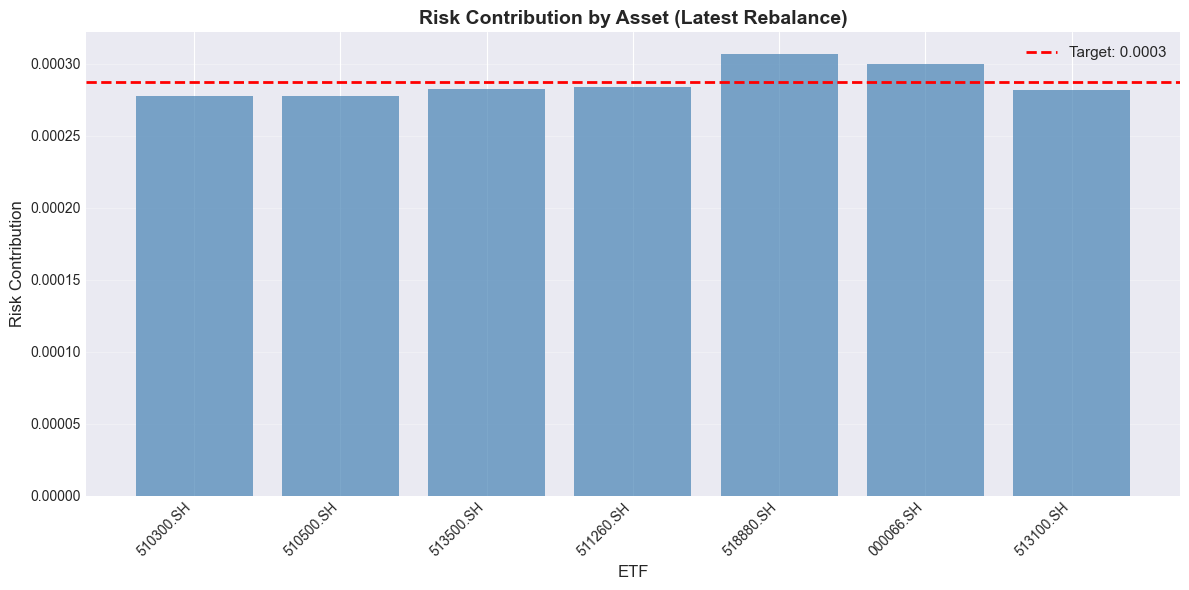


Risk Contributions (should be equal):
  510300.SH: 0.0003
  510500.SH: 0.0003
  513500.SH: 0.0003
  511260.SH: 0.0003
  518880.SH: 0.0003
  000066.SH: 0.0003
  513100.SH: 0.0003

Std dev of risk contributions: 0.000011
(Lower is better - perfect risk parity has std=0)


In [19]:
if not weights_df.empty:
    # Latest weights and risk contributions (using optimized 252-day lookback)
    latest_weights = weights_df.iloc[-1].values
    latest_returns = prices.tail(252).pct_change().dropna()
    latest_cov = latest_returns.cov()
    latest_risk_contribs = risk_contribution(latest_weights, latest_cov)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = range(len(latest_risk_contribs))
    ax.bar(x, latest_risk_contribs, alpha=0.7, color='steelblue')
    ax.axhline(latest_risk_contribs.mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Target: {latest_risk_contribs.mean():.4f}')
    ax.set_xticks(x)
    ax.set_xticklabels(weights_df.columns, rotation=45, ha='right')
    ax.set_title('Risk Contribution by Asset (Latest Rebalance)', 
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Risk Contribution', fontsize=12)
    ax.set_xlabel('ETF', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print("\nRisk Contributions (should be equal):")
    for etf, rc in zip(weights_df.columns, latest_risk_contribs):
        print(f"  {etf}: {rc:.4f}")
    print(f"\nStd dev of risk contributions: {latest_risk_contribs.std():.6f}")
    print("(Lower is better - perfect risk parity has std=0)")

## 9. Export Results

Save key results for documentation.

In [20]:
# Save results to dict for documentation
export_results = {
    'backtest_period': f"{equity.index[0].strftime('%Y-%m-%d')} to {equity.index[-1].strftime('%Y-%m-%d')}",
    'final_value': results['final_value'],
    'total_return': results['total_return'],
    'metrics': portfolio_metrics,
    'benchmark_metrics': benchmark_metrics,
    'rebalance_count': results['rebalance_count'],
    'trade_count': results['trade_count'],
    'total_commissions': results['total_commissions']
}

print("Results ready for export to v1.0_baseline.md")
print(f"\nBacktest period: {export_results['backtest_period']}")
print(f"Final value: ¥{export_results['final_value']:,.0f}")
print(f"Total return: {export_results['total_return']:.2%}")

Results ready for export to v1.0_baseline.md

Backtest period: 2018-01-02 to 2026-01-28
Final value: ¥1,697,909
Total return: 69.79%


## 10. Trading Instructions (Forward-Looking)

Generate actionable trading instructions for implementing the All Weather strategy with ¥30,000 initial capital.

This section provides:
- Exact number of shares to buy for each ETF
- Next rebalancing dates
- Portfolio tracking with PnL
- Transaction costs included

In [21]:
# Trading parameters
INITIAL_CAPITAL = 30_000  # ¥30,000 starting capital
COMMISSION_RATE = 0.0003  # 0.03% commission

# Get current prices (latest available)
current_prices = prices.iloc[-1]
current_date = prices.index[-1]

print("="*70)
print("ALL WEATHER STRATEGY - TRADING INSTRUCTIONS")
print("="*70)
print(f"\nCurrent Date: {current_date.date()}")
print(f"Initial Capital: ¥{INITIAL_CAPITAL:,.0f}")
print(f"Commission Rate: {COMMISSION_RATE:.2%}")

# Calculate current risk parity weights
recent_returns = prices.tail(252).pct_change().dropna()
current_weights = optimize_weights(recent_returns)

print("\n" + "-"*70)
print("TARGET ALLOCATION (Risk Parity Weights)")
print("-"*70)

weight_allocation = pd.DataFrame({
    'ETF': prices.columns,
    'Weight': current_weights,
    'Target Value (¥)': current_weights * INITIAL_CAPITAL
}).sort_values('Weight', ascending=False)

print(weight_allocation.to_string(index=False))
print(f"\nTotal: {current_weights.sum():.4f}")

ALL WEATHER STRATEGY - TRADING INSTRUCTIONS

Current Date: 2026-01-28
Initial Capital: ¥30,000
Commission Rate: 0.03%

----------------------------------------------------------------------
TARGET ALLOCATION (Risk Parity Weights)
----------------------------------------------------------------------
      ETF  Weight  Target Value (¥)
511260.SH  0.7741        23222.1979
510300.SH  0.0485         1454.4603
518880.SH  0.0470         1410.1395
510500.SH  0.0354         1062.8739
513500.SH  0.0349         1046.4939
000066.SH  0.0321          962.5772
513100.SH  0.0280          841.2573

Total: 1.0000


In [22]:
# Calculate exact shares to buy (round to 100-share lots for A-shares)
print("\n" + "="*70)
print("INITIAL PURCHASE INSTRUCTIONS")
print("="*70)
print(f"\nExecute on: {current_date.date()} (or next trading day)")
print("\n" + "-"*70)

trades = []
total_cost = 0
remaining_cash = INITIAL_CAPITAL

for etf, weight, target_value in weight_allocation.values:
    price = current_prices[etf]
    
    # Calculate shares (round to 100-share lots)
    shares = round(target_value / price / 100) * 100
    
    if shares > 0:
        cost = shares * price
        commission = cost * COMMISSION_RATE
        total_cost_with_commission = cost + commission
        
        # Check if we have enough cash
        if total_cost_with_commission <= remaining_cash:
            trades.append({
                'ETF': etf,
                'Shares': int(shares),
                'Price': price,
                'Cost': cost,
                'Commission': commission,
                'Total': total_cost_with_commission
            })
            remaining_cash -= total_cost_with_commission
            total_cost += total_cost_with_commission

trades_df = pd.DataFrame(trades)

print(f"{'ETF':<15} {'Shares':>8} {'Price':>10} {'Cost':>12} {'Commission':>12} {'Total':>12}")
print("-"*70)

for _, row in trades_df.iterrows():
    print(f"{row['ETF']:<15} {row['Shares']:>8,} {row['Price']:>10.2f} "
          f"{row['Cost']:>12,.2f} {row['Commission']:>12,.2f} {row['Total']:>12,.2f}")

print("-"*70)
print(f"{'TOTAL':<15} {'':<8} {'':<10} {'':<12} {'':<12} {total_cost:>12,.2f}")
print(f"\nRemaining Cash: ¥{remaining_cash:,.2f}")
print(f"Total Invested: ¥{total_cost:,.2f} ({total_cost/INITIAL_CAPITAL:.1%})")


INITIAL PURCHASE INSTRUCTIONS

Execute on: 2026-01-28 (or next trading day)

----------------------------------------------------------------------
ETF               Shares      Price         Cost   Commission        Total
----------------------------------------------------------------------
511260.SH            200     134.67    26,934.00         8.08    26,942.08
510300.SH            300       4.72     1,417.50         0.43     1,417.93
518880.SH            100      11.28     1,128.00         0.34     1,128.34
----------------------------------------------------------------------
TOTAL                                                            29,488.34

Remaining Cash: ¥511.66
Total Invested: ¥29,488.34 (98.3%)


In [23]:
# Calculate next rebalancing dates (weekly on Mondays)
from datetime import timedelta

print("\n" + "="*70)
print("REBALANCING SCHEDULE")
print("="*70)

# Find next Monday
days_ahead = 0 - current_date.weekday()
if days_ahead <= 0:
    days_ahead += 7
next_monday = current_date + timedelta(days=days_ahead)

print("\nNext 5 rebalancing dates (Weekly Mondays):")
for i in range(5):
    rebal_date = next_monday + timedelta(weeks=i)
    print(f"  {i+1}. {rebal_date.date()}")

print("\n⚠️  IMPORTANT REBALANCING NOTES:")
print("  - Rebalance every Monday (or next trading day if holiday)")
print("  - Use 252-day lookback to recalculate weights")
print("  - Buy/sell to match target allocation")
print("  - Include 0.03% commission in calculations")
print("  - Track portfolio value changes (PnL affects next rebalance)")


REBALANCING SCHEDULE

Next 5 rebalancing dates (Weekly Mondays):
  1. 2026-02-02
  2. 2026-02-09
  3. 2026-02-16
  4. 2026-02-23
  5. 2026-03-02

⚠️  IMPORTANT REBALANCING NOTES:
  - Rebalance every Monday (or next trading day if holiday)
  - Use 252-day lookback to recalculate weights
  - Buy/sell to match target allocation
  - Include 0.03% commission in calculations
  - Track portfolio value changes (PnL affects next rebalance)


In [24]:
# Show portfolio tracking template
print("\n" + "="*70)
print("PORTFOLIO TRACKING TEMPLATE")
print("="*70)

print("\nAfter initial purchase, track your portfolio like this:\n")

# Create tracking table
tracking = pd.DataFrame({
    'ETF': [row['ETF'] for _, row in trades_df.iterrows()],
    'Shares': [int(row['Shares']) for _, row in trades_df.iterrows()],
    'Purchase Price': [row['Price'] for _, row in trades_df.iterrows()],
    'Current Price': ['[UPDATE]'] * len(trades_df),
    'Market Value': ['[CALC]'] * len(trades_df),
    'PnL': ['[CALC]'] * len(trades_df)
})

print(tracking.to_string(index=False))

print("\n" + "-"*70)
print("Instructions:")
print("  1. Update 'Current Price' with latest ETF prices")
print("  2. Calculate 'Market Value' = Shares × Current Price")
print("  3. Calculate 'PnL' = Market Value - (Shares × Purchase Price)")
print("  4. Total Portfolio Value = Sum(Market Value) + Cash")
print("  5. On rebalance day: Calculate new target allocation based on total value")
print("  6. Execute trades to match new targets (account for commissions)")


PORTFOLIO TRACKING TEMPLATE

After initial purchase, track your portfolio like this:

      ETF  Shares  Purchase Price Current Price Market Value    PnL
511260.SH     200        134.6700      [UPDATE]       [CALC] [CALC]
510300.SH     300          4.7250      [UPDATE]       [CALC] [CALC]
518880.SH     100         11.2800      [UPDATE]       [CALC] [CALC]

----------------------------------------------------------------------
Instructions:
  1. Update 'Current Price' with latest ETF prices
  2. Calculate 'Market Value' = Shares × Current Price
  3. Calculate 'PnL' = Market Value - (Shares × Purchase Price)
  4. Total Portfolio Value = Sum(Market Value) + Cash
  5. On rebalance day: Calculate new target allocation based on total value
  6. Execute trades to match new targets (account for commissions)


In [25]:
# Example: What to do at first rebalance
print("\n" + "="*70)
print("EXAMPLE: FIRST REBALANCE PROCEDURE")
print("="*70)

print(f"\nDate: {next_monday.date()} (Next Monday)\n")

print("Step 1: Calculate Portfolio Value")
print("-" * 40)
print("  • Get current prices for all holdings")
print("  • Calculate: Total Value = Sum(Shares × Current Price) + Cash")
print("  • Example: If portfolio grew to ¥30,500")

print("\nStep 2: Recalculate Risk Parity Weights")
print("-" * 40)
print("  • Use latest 252 days of price data")
print("  • Run: weights = optimize_weights(returns.tail(252))")
print("  • Calculate new target values = weights × Total Value")

print("\nStep 3: Calculate Required Trades")
print("-" * 40)
print("  • For each ETF:")
print("    - Current Value = Shares × Current Price")
print("    - Target Value = Weight × Total Portfolio Value")
print("    - Trade Value = Target Value - Current Value")
print("    - Shares to Trade = round(Trade Value / Price / 100) × 100")

print("\nStep 4: Execute Trades")
print("-" * 40)
print("  • Buy if shares > 0, Sell if shares < 0")
print("  • Account for 0.03% commission on each trade")
print("  • Update cash: Cash -= (Trade Value + Commission)")

print("\nStep 5: Update Portfolio Record")
print("-" * 40)
print("  • Record new share counts")
print("  • Record new purchase prices (cost basis)")
print("  • Update remaining cash")
print("  • Wait until next Monday for next rebalance")

print("\n" + "="*70)
print("📊 Keep this notebook handy for future rebalancing!")
print("="*70)


EXAMPLE: FIRST REBALANCE PROCEDURE

Date: 2026-02-02 (Next Monday)

Step 1: Calculate Portfolio Value
----------------------------------------
  • Get current prices for all holdings
  • Calculate: Total Value = Sum(Shares × Current Price) + Cash
  • Example: If portfolio grew to ¥30,500

Step 2: Recalculate Risk Parity Weights
----------------------------------------
  • Use latest 252 days of price data
  • Run: weights = optimize_weights(returns.tail(252))
  • Calculate new target values = weights × Total Value

Step 3: Calculate Required Trades
----------------------------------------
  • For each ETF:
    - Current Value = Shares × Current Price
    - Target Value = Weight × Total Portfolio Value
    - Trade Value = Target Value - Current Value
    - Shares to Trade = round(Trade Value / Price / 100) × 100

Step 4: Execute Trades
----------------------------------------
  • Buy if shares > 0, Sell if shares < 0
  • Account for 0.03% commission on each trade
  • Update cash: Cash 